#### Start with select columns of the biggest csv, merge them with descriptions csv, and remove users with fewer than 3 checkins and beers with fewer than 2 checkins

In [1]:
import pandas as pd

checkins = pd.read_csv('comboframe.csv', usecols=['beer_id', 'rating_user',
                                                  'rating_global', 'user_id',
                                                  'abv', 'brewery_name',
                                                  'beer_style', 'beer_name',
                                                  'checkin_id'])
# only allow each user one rating for each beer
checkins.drop_duplicates(subset=['beer_id', 'user_id'], inplace=True)
print(checkins.shape)
descrips = pd.read_csv('descriptions.csv')
print(descrips.shape)

(1894852, 9)
(114347, 2)


In [2]:
# merge in the descriptions and see how many checkins remain
checkins = checkins.merge(descrips, how='inner')
checkins.shape

(1394388, 10)

In [3]:
checkins = checkins[checkins.user_id.map(checkins.groupby('user_id').size() > 2)]
checkins.shape

(1155870, 10)

In [4]:
checkins = checkins[checkins.beer_id.map(checkins.groupby('beer_id').size() > 1)]
checkins.shape

(1129526, 10)

In [5]:
checkins.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1129526 entries, 0 to 1394387
Data columns (total 10 columns):
checkin_id          1129526 non-null int64
beer_id             1129526 non-null int64
user_id             1129526 non-null int64
rating_user         1129526 non-null float64
brewery_name        1129526 non-null object
beer_name           1129526 non-null object
beer_style          1129526 non-null object
rating_global       1104319 non-null float64
abv                 1129526 non-null float64
beer_description    1129526 non-null object
dtypes: float64(3), int64(3), object(4)
memory usage: 94.8+ MB


In [6]:
# remove the ones with no global ratings
checkins.dropna(subset=['rating_global'], axis=0, inplace=True)
# and the zeros
checkins = checkins[checkins.rating_global > 0]
checkins.shape

(1103369, 10)

In [7]:
checkins.head(2)

,checkin_id,beer_id,user_id,rating_user,brewery_name,beer_name,beer_style,rating_global,abv,beer_description
0,821797539,2095023,3340203,3.75,Stone Brewing,Stone Scorpion Bowl IPA,IPA - American,3.73789,7.5,To create a recipe so tropical and fruity with...
1,793777280,2095023,2166716,3.50,Stone Brewing,Stone Scorpion Bowl IPA,IPA - American,3.73789,7.5,To create a recipe so tropical and fruity with...


In [8]:
checkins[['checkin_id','user_id','rating_user','rating_global','abv']].describe()

,checkin_id,user_id,rating_user,rating_global,abv
count,1.103369e+06,1.103369e+06,1.103369e+06,1.103369e+06,1.103369e+06
mean,7.546046e+08,2.094023e+06,3.826596e+00,3.828369e+00,6.927206e+00
std,1.028723e+08,1.729344e+06,5.743143e-01,2.891699e-01,1.984595e+00
min,9.773630e+05,1.900000e+01,1.000000e-01,1.536520e+00,0.000000e+00
25%,7.420015e+08,6.537330e+05,3.500000e+00,3.657270e+00,5.700000e+00
50%,7.892611e+08,1.651536e+06,4.000000e+00,3.811980e+00,6.700000e+00
75%,8.113865e+08,3.161810e+06,4.250000e+00,4.010630e+00,7.900000e+00
max,8.491104e+08,7.450082e+06,5.000000e+00,4.903410e+00,6.500000e+01


In [9]:
sum(checkins.abv == 0)

3284

In [10]:
# Those will mess up the predictions, since abv is a strong correlator with ratings.  Also get rid of that 65% abv!!
checkins = checkins[(checkins.abv > 0) & (checkins.abv < 30)]
checkins[['abv']].describe()

,abv
count,1.100044e+06
mean,6.946279e+00
std,1.932038e+00
min,3.000000e-01
25%,5.700000e+00
50%,6.700000e+00
75%,7.900000e+00
max,2.900000e+01


### Let's start with a scenario where we have no ratings for a user.  We'll say the user is looking at a menu of 10 beers.  With only this info, our only recourse is to recommend things in order of their global mean ratings.  Let's simulate that by taking the users who have exactly 10 ratings and seeing how the user ranked the top 3 recommendations.

In [11]:
# a mapping from user to number of ratings can be helpful in many situations
usercounts = checkins.groupby('user_id').size()
tens = checkins[checkins.user_id.map(usercounts) == 10].set_index('user_id').sort_index()
len(tens)

4130

Looks like we have 413 users.  Here's the "digital menu" staring our first user in the face:

In [12]:
tens.reset_index()[['brewery_name', 'beer_name']].head(10)

,brewery_name,beer_name
0,Half Acre Beer Company,Logue
1,Yamorido,Coup De Grace
2,Westside Ale Works,Weekend Juice NEIPA
3,Chilly Water Brewing Company,Wagon Wheel
4,6 beers brewing co.,Limelight
5,Hemingway's Brewery,Doug's Courage XPA
6,Upslope Brewing Company,Hazy IPA
7,Half Acre Beer Company,Alive In Its Jaws
8,Uchu Brewing,Aldebaran (#65)
9,Y.Market Brewing,Hysteric IPA


Here's how those 10 are rated globally, from best to worst:

In [13]:
t = tens.head(10)
t.reset_index()[['beer_name', 'rating_global']].sort_values('rating_global', ascending=False)

,beer_name,rating_global
7,Alive In Its Jaws,4.28491
0,Logue,4.10604
8,Aldebaran (#65),4.00521
6,Hazy IPA,3.87626
2,Weekend Juice NEIPA,3.74539
9,Hysteric IPA,3.74126
4,Limelight,3.67035
1,Coup De Grace,3.64394
3,Wagon Wheel,3.60677
5,Doug's Courage XPA,3.60528


...and how the user rated them:

In [14]:
t.reset_index()[['beer_name', 'rating_user']].sort_values('rating_user', ascending=False)

,beer_name,rating_user
0,Logue,3.75
7,Alive In Its Jaws,3.75
8,Aldebaran (#65),3.75
1,Coup De Grace,3.50
4,Limelight,3.50
5,Doug's Courage XPA,3.50
6,Hazy IPA,3.50
9,Hysteric IPA,3.50
2,Weekend Juice NEIPA,3.25
3,Wagon Wheel,3.25


For this first user, the global mean works great:  The top 3 recommendations were the 3 the user ended up rating the highest.  This user would be happy to use this recommender again.  Before this user ever gets down to the 5th recommendation, the one that was tied for last in his actual ratings, he will hopefully have given the recommender some feedback (ratings) to make more informed decisions.  Also, a user in this situation very likely may repeat orders once he's happy with one or two, so the demands of such a recommender are different from, say, a book recommender.   Now let's see how this method works for all 413 users here. 

In [15]:
import numpy as np

In [16]:
# make a func to deal with ties in rankings
def untied_rank(arr, vals):
    '''
    Measure how well the input vals (list or np.array) has chosen
    the top values of input arr (np.array). 
    vals must be subset of arr.
    1.0 is perfect, 0.0 is worst.
    '''
    fails = 0
    poss_fails = 0
    ordered = np.sort(arr)
    if max(ordered) == min(ordered): return 0.5  # like guessing, if all equal
    for i in range(len(vals)):
        fails += sum(arr > vals[i])
        arr = np.delete(arr, np.where(arr == vals[i])[0][0])
        poss_fails += sum(ordered > ordered[i])
    
    return 1 - fails / poss_fails
    

In [17]:
# The perfect rankings for the first user, above
untied_rank(t.rating_user.values, t.rating_user.values[np.argsort(t.rating_global.values)[:-4:-1]])

1.0

In [18]:
scores = []
for u in tens.index.unique():
    uten = tens.loc[u, ['rating_user','rating_global']]
    scores.append(untied_rank(uten.rating_user.values, 
                              uten.rating_user.values[np.argsort(uten.rating_global.values)[:-4:-1]]))
print(f'The average score picking the top 3 globally rated for 413 "menus":  {np.mean(scores)}')

The average score picking the top 3 globally rated for 413 "menus":  0.7535366940665592


Let's see what a .75 score looks like for one user:

In [19]:
scores[36]

0.75

The global rankings/recommendations for that user:

In [20]:
t = tens.iloc[360:370, :]
t.reset_index()[['beer_name', 'rating_global']].sort_values('rating_global', ascending=False)

,beer_name,rating_global
5,Cone Wars: Idaho 7 Fresh Hop IPA,4.03846
0,Wicked Haze,3.91730
9,The Emergent IPA,3.91379
1,Melon Rye IIIPA,3.90668
6,Citra IPA,3.81579
3,Humulus Unum Amarillo,3.77632
4,Capo Blood Orange IPA,3.71512
2,Fraud Alert,3.62619
7,Hophoria IPA,3.58289
8,Bullseye Pale Ale,3.57362


...and actual ratings:

In [21]:
t.reset_index()[['beer_name', 'rating_user']].sort_values('rating_user', ascending=False)

,beer_name,rating_user
0,Wicked Haze,4.25
5,Cone Wars: Idaho 7 Fresh Hop IPA,4.00
1,Melon Rye IIIPA,3.75
6,Citra IPA,3.75
2,Fraud Alert,3.50
3,Humulus Unum Amarillo,3.50
4,Capo Blood Orange IPA,3.50
7,Hophoria IPA,3.50
8,Bullseye Pale Ale,3.50
9,The Emergent IPA,3.50


That's good recommendations:  The top 2 came in second and first, and the 3rd rec was actually tied for 5th

The worst-case scenario for this recommender method is when a user rates everything pretty equally, and the high global rating beers are unlikely to be picked out from the others by this user.  An example is this user whose ratings score 0.0 by this system:

In [22]:
t = tens.iloc[90:100, :]
t.reset_index()[['beer_name', 'rating_global']].sort_values('rating_global', ascending=False)

,beer_name,rating_global
6,Peconic Project,4.07962
7,Wicked Smaht,3.97449
1,DJ Night,3.80664
3,Sigint,3.70455
9,Citralization,3.70051
5,Go Bigg Or Go Home IPA,3.66873
8,Smilin' Mike,3.62981
4,Useful Idiot,3.59771
2,Daayani,3.59000
0,West Coast IPA,3.56235


...and how this user made the recommender look horrible:

In [23]:
t.reset_index()[['beer_name', 'rating_user']].sort_values('rating_user', ascending=False)

,beer_name,rating_user
4,Useful Idiot,4.50
5,Go Bigg Or Go Home IPA,4.25
0,West Coast IPA,4.00
1,DJ Night,4.00
2,Daayani,4.00
3,Sigint,4.00
6,Peconic Project,4.00
7,Wicked Smaht,4.00
8,Smilin' Mike,4.00
9,Citralization,4.00


The recommender's top 3 picks actually all tied for 3rd in the user's ratings...and for last.

Before moving on, here's how the same system does for picking top 1 to top 10:

In [24]:
allscores = []
for x in range(2,12):
    scores = []
    for u in tens.index.unique():
        uten = tens.loc[u, ['rating_user','rating_global']]
        scores.append(untied_rank(uten.rating_user.values, 
                    uten.rating_user.values[np.argsort(uten.rating_global.values)[:-x:-1]]))
    allscores.append(np.mean(scores))

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

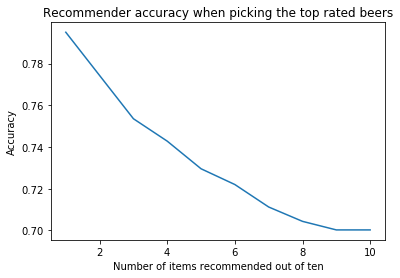

In [26]:
plt.plot(range(1,11), allscores)
plt.title('Recommender accuracy when picking the top rated beers')
plt.xlabel('Number of items recommended out of ten')
plt.ylabel('Accuracy');

Sanity check that random picks score about 0.5 ---

In [27]:
scores = []
for u in tens.index.unique():
    uten = tens.loc[u, ['rating_user','rating_global']]
    scores.append(untied_rank(uten.rating_user.values, 
                    uten.rating_user.values[np.random.permutation(range(10))[:3]]))
print(f'Accuracy for randomly choosing 3 beers off the menu: {np.mean(scores)}')

Accuracy for randomly choosing 3 beers off the menu: 0.5341473444293866


#### Now what about if we don't even have any global ratings for a beer?  This could be for a new beer, or maybe a brewer is trying to figure out what beer to brew in order to get good ratings.  

Our main weapons here will be the one numerical feature that tends to correlate to ratings most, and the words comprising the brewery name, the beer name, and the beer description, as provided by the brewery.  The numerical feature is the alcohol by volume (abv) and we'll train a Linear Regressor on that plus a binary vector encoding of the words we have for each beer.

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDRegressor

I set the `max_df` threshold (the highest ratio of descriptions a word can appear in before it is dropped for being considered not informative enough to keep making noise) to 0.17 -- That was the divider that just barely keeps 'hop' and 'dry' but not 'brewed' and 'ale'.  
I also made the term vectors binary, since the goal is to identify keywords that correlate to ratings, not to classify the text as belonging to some category.  This makes the relative importance of the words easier to interpret after training, too.  If the word "hoppy" appears 3 times in one description, it doesn't seem like it should drive down the word's weight for all the beers whose descriptions have it only once.

In [29]:
# Add the beer and brewery names to the description
checkins['beer_description'] = checkins.brewery_name + ' ' + checkins.beer_name + ' ' + checkins.beer_description

In [30]:
checkins.head(1)

,checkin_id,beer_id,user_id,rating_user,brewery_name,beer_name,beer_style,rating_global,abv,beer_description
0,821797539,2095023,3340203,3.75,Stone Brewing,Stone Scorpion Bowl IPA,IPA - American,3.73789,7.5,Stone Brewing Stone Scorpion Bowl IPA To creat...


In [31]:
# vectorize just one of each beer description, to not skew document frequency
uniqs = checkins[['beer_id', 'beer_description']].drop_duplicates(subset=['beer_id'])
uniqs.shape

(87017, 2)

In [32]:
cv = CountVectorizer(stop_words='english', min_df=5, max_df=0.17, binary=True)
vecs = cv.fit_transform(uniqs.beer_description)
vecs.shape

(87017, 20133)

Now we're dealing with sparse matrices, so we'll need some scipy help

In [33]:
from scipy.sparse import csr_matrix, hstack
# get the abv and global mean for each unique beer, to align with the term vectors for training
uniqs['abv'] = uniqs.beer_id.map(checkins.groupby('beer_id')['abv'].mean())
uniqs['rating_global'] = uniqs.beer_id.map(checkins.groupby('beer_id')['rating_global'].mean())
# tack the abvs onto the vecs, after scaling them down to around the binary 1's
vecs = hstack([vecs, uniqs.abv.values[:, np.newaxis] / 5.0])  # need the new axis for hstack
vecs = csr_matrix(vecs)

In [34]:
vecs.shape

(87017, 20134)

Let's take a quick look at how the global ratings are distributed, just to know how random guessing would do for predicting ratings for a new beer:

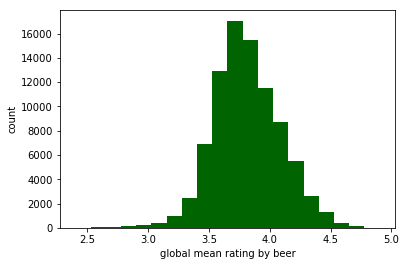

In [35]:
# ignore the couple of ratings that are outliers to the downside, for clarity in the chart
uniqs[uniqs.rating_global > 2.4].rating_global.plot(kind='hist', bins=20, color='darkgreen')
plt.xlabel('global mean rating by beer')
plt.ylabel('count');

That's a normal distribution leaning a little bit left for whatever reason.  
The standard deviation should be a pretty good indicator of RMSE:

In [36]:
# shuffle the ratings
globmeans = np.random.permutation(uniqs.rating_global.values)
# Calculate the mean of all but 1000 beers
head = globmeans[:-1000]
tail = globmeans[-1000:]
meanhead = np.mean(head)
# See how far each of the final 1000 is from that mean
devs = tail - meanhead
# Get the RMSE of those estimates
sumsqerr = np.dot(devs, devs)
rmse = np.sqrt(sumsqerr / len(devs))
print(f'standard deviation of the first ratings: {np.std(head)}')
print(f'RMSE of the test batch: {rmse}')

standard deviation of the first ratings: 0.27731986651059803
RMSE of the test batch: 0.2713745087355389


So that's kind of a baseline goal to beat, and we'll see how much better a Regressor can do.

We've fit a Vectorizer to all words and added abvs/5, but we'll only train on some of them, and then test on the rest.  
So we need to split off the test group now.  
To the tens group from before, we'll add the elevens, for more numbers.  We can test the Regression on their global means and then see how recommendations based on the model's predictions do with our custom accuracy score from before.  Most likely, the model will fare halfway between random choices and known global means.

In [37]:
testers = checkins[(checkins.user_id.map(usercounts) == 10) | 
                   (checkins.user_id.map(usercounts) == 11)].set_index('user_id').sort_index()

In [38]:
len(testers)

6759

We're just using the unique term vectors to train and test on, so now is the time to split off all the beers that these tens and elevens have rated.

In [39]:
testIDs = set(testers.beer_id)

In [40]:
testbeers = uniqs[uniqs.beer_id.apply(lambda id: id in testIDs)]
testbeers.shape

(4513, 4)

In [41]:
trainbeers = uniqs[uniqs.beer_id.apply(lambda id: id not in testIDs)]
trainbeers.shape

(82504, 4)

In [42]:
# the vecs sparse array is struggling to split into train and test based on the above boolean array, so plan B:
uniqs.reset_index(inplace=True)
# now with integer range as index, the uniqs/vecs index can be looked up for each beer_id
beer_id_to_vecs_index = dict(zip(uniqs.beer_id, uniqs.index))
vi_test = testbeers.beer_id.map(beer_id_to_vecs_index)
vi_train = trainbeers.beer_id.map(beer_id_to_vecs_index)

In [43]:
trainX = vecs.toarray()[vi_train, :]
testX = vecs.toarray()[vi_test, :]

In [44]:
trainY = trainbeers.rating_global
testY = testbeers.rating_global
print(f'{len(trainY)} training beers and {len(testY)} test beers')

82504 training beers and 4513 test beers


In [45]:
sgd = SGDRegressor(penalty='elasticnet', random_state=0, max_iter=1000, tol=1e-5, l1_ratio=0.05, verbose=1)
sgd.fit(csr_matrix(trainX), trainY)

preds = sgd.predict(testX)
diffs = preds - testY
sumsq = np.dot(diffs, diffs)
rmse = np.sqrt(sumsq / len(diffs))
rmse

-- Epoch 1
Norm: 3.45, NNZs: 18391, Bias: 0.113478, T: 82504, Avg. loss: 0.247669
Total training time: 0.07 seconds.
-- Epoch 2
Norm: 3.79, NNZs: 18185, Bias: 0.167238, T: 165008, Avg. loss: 0.203619
Total training time: 0.12 seconds.
-- Epoch 3
Norm: 4.03, NNZs: 18071, Bias: 0.211476, T: 247512, Avg. loss: 0.190149
Total training time: 0.17 seconds.
-- Epoch 4
Norm: 4.21, NNZs: 17973, Bias: 0.250494, T: 330016, Avg. loss: 0.181073
Total training time: 0.23 seconds.
-- Epoch 5
Norm: 4.37, NNZs: 17890, Bias: 0.285942, T: 412520, Avg. loss: 0.173974
Total training time: 0.29 seconds.
-- Epoch 6
Norm: 4.49, NNZs: 17833, Bias: 0.318665, T: 495024, Avg. loss: 0.168024
Total training time: 0.35 seconds.
-- Epoch 7
Norm: 4.63, NNZs: 17780, Bias: 0.349613, T: 577528, Avg. loss: 0.162971
Total training time: 0.41 seconds.
-- Epoch 8
Norm: 4.73, NNZs: 17746, Bias: 0.378543, T: 660032, Avg. loss: 0.158427
Total training time: 0.46 seconds.
-- Epoch 9
Norm: 4.83, NNZs: 17727, Bias: 0.406207, T: 74

0.18749775054311205

That's a pretty good improvement from just guessing.  Let's see what words were important, and how much abv mattered.

In [46]:
influencers = sorted(enumerate(sgd.coef_), key=lambda x: abs(x[1]), reverse=True)
influencers[:11]

[(17228, 0.50686279220863983),
 (20133, 0.49121573087755716),
 (3168, 0.47855818997624389),
 (18903, -0.42229361962574269),
 (6780, 0.40464093614146163),
 (3311, 0.35504994322429345),
 (12915, -0.30869111345802763),
 (16374, 0.29445142113229972),
 (3402, 0.29318122609719283),
 (14158, 0.27980232261017818),
 (15341, 0.27888629371666618)]

Mostly positive weightings, and abv looks like the second on the list (20134 features after tacking on abv).

In [49]:
def plot_influencers(countvec, sorted_weights, start_idx, count):
    plt.bar(np.arange(count), [(i[1]) for i in sorted_weights[start_idx:start_idx+count]],
            color='darkgreen')
    plt.xticks(np.arange(count), 
               [countvec.get_feature_names()[i[0]] if i[0]
                != len(sorted_weights)-1 else 'ABV' 
                for i in sorted_weights[start_idx:start_idx+count]],
                rotation='vertical')
    plt.ylabel('coefficient')
    plt.show()

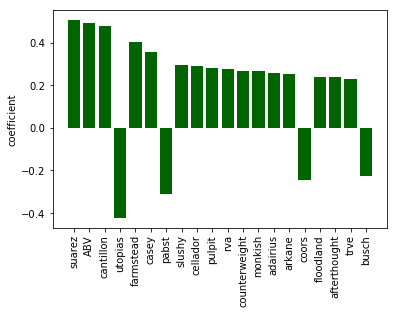

In [50]:
plot_influencers(cv, influencers, 0, 20)

Mostly brewery names and abv dominating the weights.

Let's just take it for a run through the "menus" and see how accurate it is.

Random guesses first:

In [70]:
scores = []
for u in testers.index.unique():
    udf = testers.loc[u, ['rating_user','rating_global']]
    scores.append(untied_rank(udf.rating_user.values, 
                    udf.rating_user.values[np.random.permutation(range(len(udf)))[:3]]))
print(f'Accuracy for randomly choosing 3 beers off the menu: {np.mean(scores)}')

Accuracy for randomly choosing 3 beers off the menu: 0.5531046725022023


Now with slightly more educated guesses:

In [ ]:
from tqdm import tqdm

scores = []
vecs = vecs.toarray()
for u in tqdm(testers.index.unique()):
    udf = testers.loc[u, ['rating_user', 'beer_id']]
    vi_test = udf.beer_id.map(beer_id_to_vecs_index)
    udf['preds'] = sgd.predict(vecs[vi_test, :])
    scores.append(untied_rank(udf.rating_user.values, 
                              udf.rating_user.values[np.argsort(udf.preds.values)[:-4:-1]]))

In [77]:
print(f'The average score picking the top 3 globally rated for {len(scores)} "menus":  {np.mean(scores)}')

The average score picking the top 3 globally rated for 652 "menus":  0.6688086805312844


As expected, halfway between guessing and using the global mean ratings.

#### Let's move on to a similar scenario, but this time we have some of the user's ratings under our belt, and can make better recommendations.